In [38]:
import geopandas as gpd
from shapely.geometry import LineString, Point
import json
from pyproj import Transformer
from shapely.geometry import MultiLineString
from shapely.ops import unary_union

In [39]:
roads = gpd.read_file('danang_segment.geojson')
rivers = gpd.read_file('danang_water.geojson')

In [40]:
roads = roads.to_crs(epsg=32648)
rivers = rivers.to_crs(epsg=32648)

In [41]:
river_lines = rivers.geometry.unary_union

C:\Users\minhp\AppData\Local\Temp\ipykernel_19836\3609590507.py:1: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  river_lines = rivers.geometry.unary_union


In [42]:
min_dist = float('inf')
max_dist = float('-inf')
distances = []

In [43]:
for road_geom in roads.geometry:
    dist = road_geom.distance(river_lines)
    distances.append(dist)
    min_dist = min(min_dist, dist)
    max_dist = max(max_dist, dist)

In [44]:
output = []
for idx, row in roads.iterrows():
    coords = list(row.geometry.coords)
    start = coords[0]
    end = coords[-1]
    dist = distances[idx]

    normalized = 1.0 - (dist - min_dist) / (max_dist - min_dist + 1e-8) 

    output.append({
        "roadname": None,
        "roadSegmentLine": {
            "type": "LineString",
            "coordinates": coords
        },
        "start_location": {
            "type": "Point",
            "coordinates": start
        },
        "end_location": {
            "type": "Point",
            "coordinates": end
        },
        "reports": [],
        "near_river": round(dist, 4),
        "groundwater_level": round(normalized, 4)
    })


In [45]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


In [46]:
min_lon = 107.880287
min_lat = 15.914756
max_lon = 108.345277
max_lat = 16.208933

In [47]:
transformer = Transformer.from_crs("EPSG:4326", "EPSG:32648", always_xy=True)
min_x, min_y = transformer.transform(min_lon, min_lat)
max_x, max_y = transformer.transform(max_lon, max_lat)

In [48]:
roads['near_river'] = distances
roads['groundwater_level'] = normalized

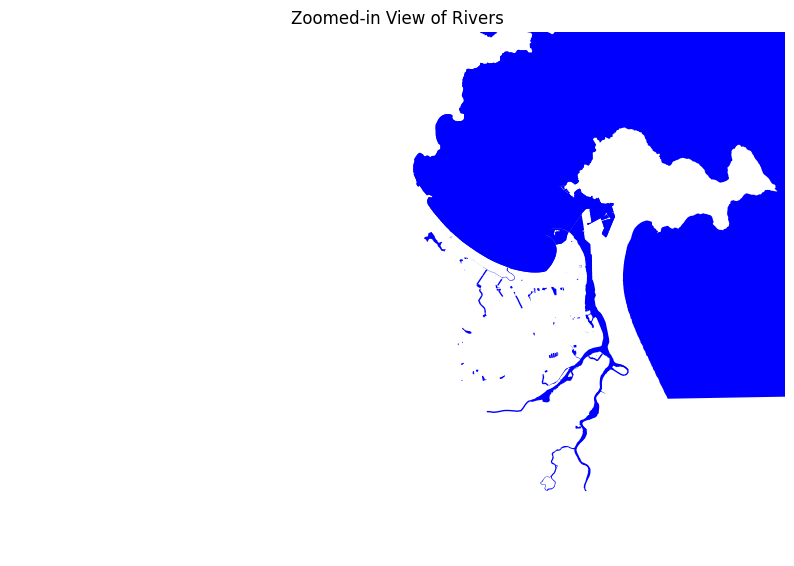

In [49]:
fig, ax = plt.subplots(figsize=(10, 10))
rivers.plot(ax=ax, color='blue', linewidth=1, label='Rivers')

ax.set_xlim(min_x, max_x)
ax.set_ylim(min_y, max_y)

plt.title("Zoomed-in View of Rivers")
plt.axis('off')
plt.show()



In [50]:
river_line_geoms = [geom for geom in rivers.geometry if geom.geom_type in ['LineString', 'MultiLineString']]
river_lines = unary_union(river_line_geoms)


In [51]:
if river_lines.geom_type == 'GeometryCollection':
    river_lines = MultiLineString([geom for geom in river_lines.geoms if geom.geom_type in ['LineString', 'MultiLineString']])

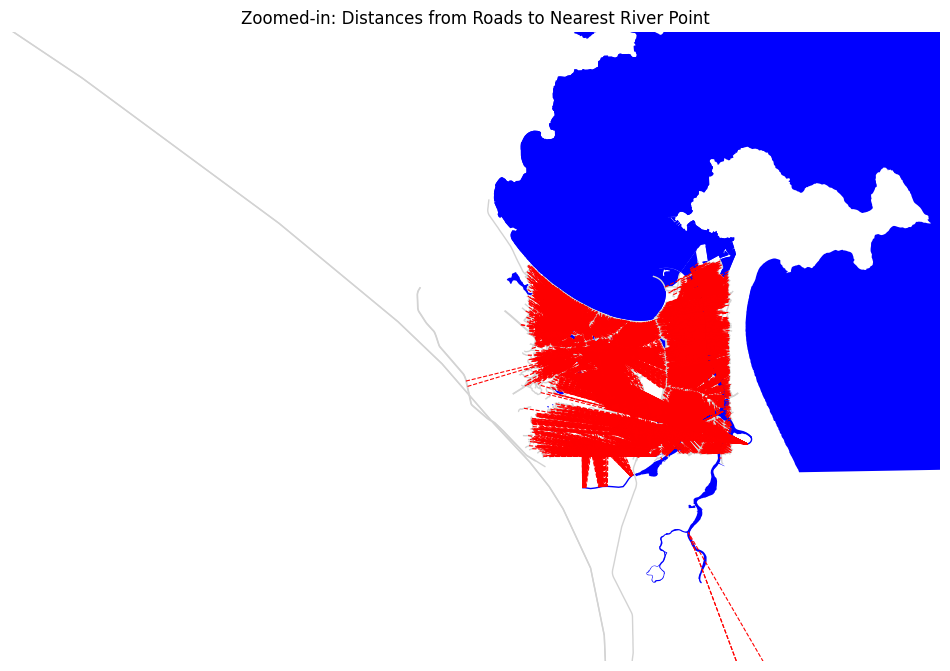

In [52]:
fig, ax = plt.subplots(figsize=(12, 12))  
rivers.plot(ax=ax, color='blue', linewidth=1, label='Rivers')
roads.plot(ax=ax, color='lightgray', linewidth=1, label='Road Segments')

for road_geom, dist in zip(roads.geometry, distances):
    midpoint = road_geom.interpolate(0.5, normalized=True)
    nearest = river_lines.interpolate(river_lines.project(midpoint))
    ax.plot([midpoint.x, nearest.x], [midpoint.y, nearest.y], color='red', linestyle='--', linewidth=0.8)

ax.set_xlim(min_x, max_x)
ax.set_ylim(min_y, max_y)

plt.title("Zoomed-in: Distances from Roads to Nearest River Point")
plt.axis('off')
plt.show()